This version included no extra prior information

# Main causes for convern

- when doing the inference a large value close to 0.01 needs to be added to the prior covariance K.
- The experimental error does not change much at all when included in the hyper parameter optimisation
- Hoe Wu's implimentation was taking about 15 steps to minimize whilst mine was taking 0 to 3. seems odd.

# Yet
- my implimentation gets values that follow the curves of NICE, Hao wu's is always linear or parabolic. 

In [11]:
# imports 
from chord_geometry_int import ChordGeometryInterferometry
from magnetic_equilibrium import MagneticEquilibrium, MagneticEquilibriumSinglePoint
from interferometry import Interferometry, InterferometrySinglePoint
from density_profile import DensityProfile, DensityProfileSinglePoint
from forward_1d_triangle_int import compute_response_matrix, plot_geometry_with_mag_equi
import matplotlib.pyplot as plt


import numpy as np
from tqdm import tqdm
import scipy
from scipy.optimize import minimize, basinhopping
import optuna
import os
from pathlib import Path
import skvideo.io
import IPython

from matplotlib.backends.backend_agg import FigureCanvasAgg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import time
from datetime import timedelta
def fig2np(fig):
    canvas = FigureCanvasAgg(fig)
    canvas.draw()
    return np.array(canvas.buffer_rgba())
import torch
import random

def ReSeed(seed=0):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
ReSeed(0)

%matplotlib inline

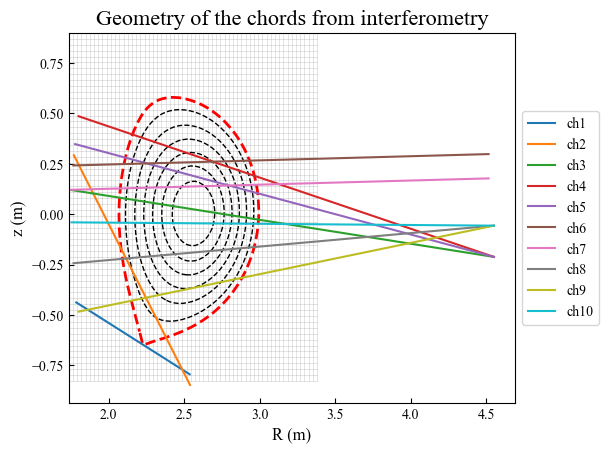

In [12]:
#load data
shot = 53259 # Shot number
t = 5.21    # Time (relative to the start of plasma)

# Geometry of the chords from interferometer (lines of sight)
geo = ChordGeometryInterferometry(f'data/WEST/{shot}/los_interferometer_{shot}.mat')

# Magnetic equilibrium calculated by equilibrium code NICE
equi_all = MagneticEquilibrium()
equi_all.load_from_imas(f'data/WEST/{shot}/imas_equilibrium_{shot}.mat', shot=shot)
equi = equi_all.get_single_point(t)

# Line integrated electron density measured by interferometer
interf_all = Interferometry()
interf_all.load_from_imas(f'data/WEST/{shot}/imas_interferometer_{shot}.mat', shot=shot)
interf = interf_all.get_single_point(t)

# Density profile calculated by equilibrium code NICE, to be used to generate synthetic data
dens_prof_all = DensityProfile()
dens_prof_all.load_from_imas(f'data/WEST/{shot}/imas_core_profiles_{shot}.mat', shot=shot)
dens_prof = dens_prof_all.get_single_point(t)

plot_geometry_with_mag_equi(geo, equi)

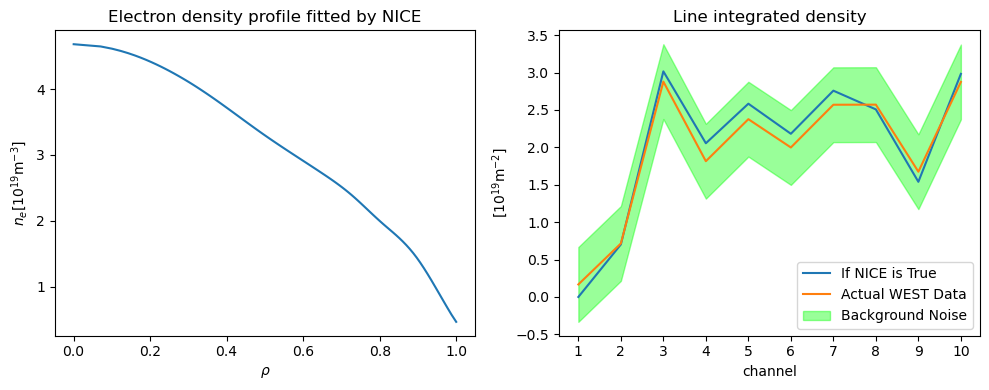

In [13]:
EXP_ER = 0.5 #0.03#background noise order of magnitude
interf_M = len(interf.channels.compressed()) #number of channels 
def data_gen(prof_1d, R):
    lid_true = R @ prof_1d
    lid_data = lid_true + np.random.normal(loc=0, scale=EXP_ER, size=len(lid_true))
    return lid_true, lid_data
                                          
# The response matrix used for calculating line integrals
R = compute_response_matrix(geo, equi, dens_prof.rho_tor_norm_1d)

lid_true, lid_data = data_gen(dens_prof.dens_1d,R)                                           

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
nice = dens_prof.dens_1d
ax1.plot(dens_prof.rho_tor_norm_1d, dens_prof.dens_1d)
ax1.set_xlabel(r'$\rho$')
ax1.set_ylabel(r'$n_e[\mathrm{10^{19} m^{-3}}]$')
ax1.set_title('Electron density profile fitted by NICE')

ax2.plot(interf.channels.compressed(), lid_true, label='If NICE is True')#'Ground Truth')
# ax2.plot(interf.channels.compressed(), lid_data, label='Synthetic Data')

ax2.plot(interf.channels.compressed(), interf.lid.compressed(), label='Actual WEST Data')
ax2.fill_between(interf.channels.compressed(), interf.lid.compressed() - EXP_ER, 
                 interf.lid.compressed()+EXP_ER, color=(0,1,0,0.4),label="Background Noise")

ax2.set_xticks(interf.channels.data)
ax2.set_xlabel('channel')
ax2.set_ylabel(r'$[\mathrm{10^{19} m^{-2}}]$')
ax2.set_title('Line integrated density')
ax2.legend()
plt.tight_layout()




In [14]:
#setting data to be used for inference
rho_1d = dens_prof.rho_tor_norm_1d
lid_d = interf.lid.compressed()

In [15]:
#defining kernel

def RandomKernelInit(NUM_RANDOM_SEARCHES, tensor):
    amp_dist = torch.distributions.uniform.Uniform(0, 50)
    l_dist = torch.distributions.uniform.Uniform(0.0001,1)
    kernel_params = []    
    for i in range(NUM_RANDOM_SEARCHES):
        amp = amp_dist.sample()
        l = l_dist.sample()
        kp = [amp,l]
        kernel_params.append(kp)
    if not tensor:
        kernel_params = [[kp_i.numpy() for kp_i in kp] for kp in kernel_params]
    return kernel_params

def Plot_l(rho, params, tensor):
    print('Plotting Length Scale. This is the static case and so length-scale is constant.')
    print('The amplitude is, Amp:',params[0])
    print('The length-scale is, l:',params[1])

def Kernel(rho1, rho2, params, tensor):
    if tensor:
        RHOA, RHOB = torch.meshgrid(rho1,rho2)
        exp=torch.exp
    else: 
        RHOA, RHOB = np.meshgrid(rho1,rho2)
        exp=np.exp
    #amplitude determins how far the model can go from the mean
    amp = params[0]
    #length scale determines smoothness, how correlated the function should be at a distance
    l = params[1]
    if tensor: return (amp**2 * exp(-((RHOA-RHOB)*(RHOA-RHOB))/(2*l**2))).T
    else: return alter(amp**2 * exp(-((RHOA-RHOB)*(RHOA-RHOB))/(2*l**2)))

def KernelPrime(rho1,rho2, params, tensor):
    if tensor:
        RHOA, RHOB = torch.meshgrid(rho1,rho2)
        exp=torch.exp

    else: 
        RHOA, RHOB = np.meshgrid(rho1,rho2)
        exp=np.exp
    #amplitude determins how far the model can go from the mean
    amp = params[0]
    #length scale determines smoothness, how correlated the function should be at a distance
    l = params[1]
    if tensor: return (amp ** 2 / l ** 2 * (RHOA - RHOB) * exp(- 0.5 * (RHOA - RHOB) ** 2 / l ** 2)).T
    else: return amp ** 2 / l ** 2 * (RHOA - RHOB) * exp(- 0.5 * (RHOA - RHOB) ** 2 / l ** 2)

def KernelPrimePrime(rho1,rho2,params, tensor):
    if tensor:
        RHOA, RHOB = torch.meshgrid(rho1,rho2)
        exp=torch.exp
    else: 
        RHOA, RHOB = np.meshgrid(rho1,rho2)
        exp=np.exp
    #amplitude determins how far the model can go from the mean
    amp = params[0]
    #length scale determines smoothness, how correlated the function should be at a distance
    l = params[1]
    if tensor: return (amp ** 2 / l ** 2 * (1 - (RHOA-RHOB) ** 2 / l ** 2) * exp(- 0.5 * (RHOA- RHOB) ** 2 / l ** 2)).T        
    else: return amp ** 2 / l ** 2 * (1 - (RHOA-RHOB) ** 2 / l ** 2) * exp(- 0.5 * (RHOA- RHOB) ** 2 / l ** 2)

#amp then l
suitable_params_range = [(0.1,100),(0.001,1)]
initial_params = [25,0.1] #these will be used if NUM_RANDOM_SEARCHES=0

Performing SciPy fitting using method: minimize
Random Initial Params
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: 37.88158
The length-scale is, l: 0.27938294


/home/daniel/anaconda3/envs/mthesis/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1693317512104/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_12182/1803630310.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cov_li = torch.diag(torch.tensor(lid_error)) # M is number of channels




FIT RESULTS
   message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 5.999302864074707
        x: [ 3.788e+01 -7.306e-01]
      nit: 1
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[1 0]
            [0 1]]
     nfev: 6
     njev: 2
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: 37.8815803527832
The length-scale is, l: -0.7306170558929443
Non positive definate matrix for K even with a small addition of 0 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-10 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-09 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-08 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-07 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-06 to the diagonal.
Non positive definate matrix for K even with

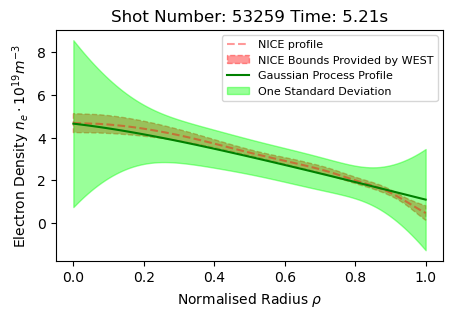

Random Initial Params
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: 20.153463
The length-scale is, l: 0.734711


FIT RESULTS
   message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.7445032596588135
        x: [ 2.015e+01  1.745e+00]
      nit: 1
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[1 0]
            [0 1]]
     nfev: 6
     njev: 2
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: 20.15346336364746
The length-scale is, l: 1.7447109913825989
Non positive definate matrix for K even with a small addition of 0 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-10 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-09 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-08 to the diagonal.
Non positive definate matrix for K even with a smal

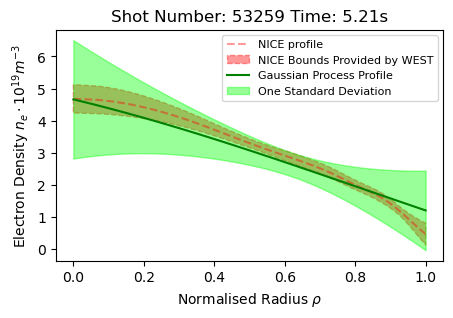

Random Initial Params
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: 1.4640778
The length-scale is, l: 0.79987866


FIT RESULTS
   message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 3.762082099914551
        x: [ 1.464e+00  7.999e-01]
      nit: 1
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[1 0]
            [0 1]]
     nfev: 39
     njev: 13
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: 1.4640778303146362
The length-scale is, l: 0.7998774855647126
Non positive definate matrix for K even with a small addition of 0 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-10 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-09 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-08 to the diagonal.
Non positive definate matrix for K even with a 

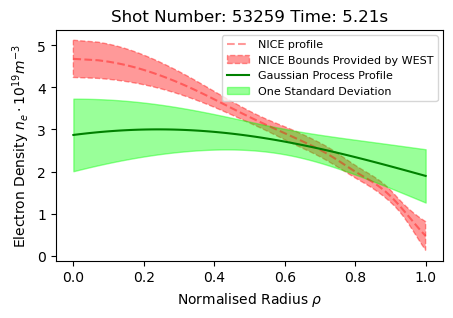

Random Initial Params
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: 19.856867
The length-scale is, l: 0.7543965


FIT RESULTS
   message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 4.029082298278809
        x: [ 1.986e+01  7.544e-01]
      nit: 0
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[1 0]
            [0 1]]
     nfev: 3
     njev: 1
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: 19.856867
The length-scale is, l: 0.7543965
Non positive definate matrix for K even with a small addition of 0 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-10 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-09 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-08 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-

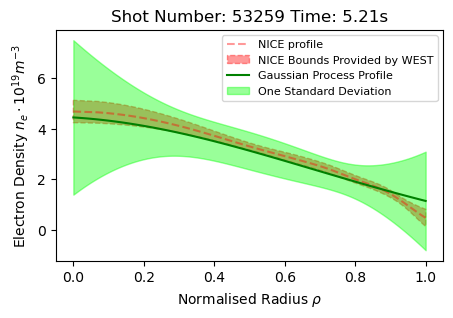

Random Initial Params
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: 28.475424
The length-scale is, l: 0.438834


FIT RESULTS
   message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 3.8459062576293945
        x: [ 2.790e+01  1.266e+00]
      nit: 1
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[1 0]
            [0 1]]
     nfev: 6
     njev: 2
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: 27.89622684505925
The length-scale is, l: 1.2662582512789489
Non positive definate matrix for K even with a small addition of 0 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-10 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-09 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-08 to the diagonal.
Non positive definate matrix for K even with a smal

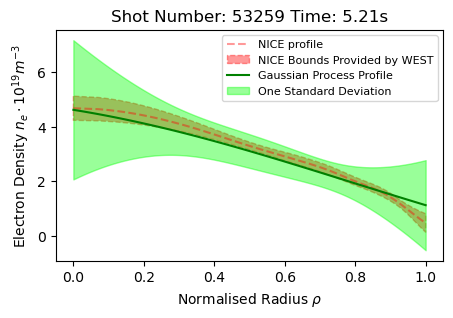

Random Initial Params
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: 31.934023
The length-scale is, l: 0.52471346


FIT RESULTS
   message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 6.535161972045898
        x: [ 3.193e+01  5.247e-01]
      nit: 0
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[1 0]
            [0 1]]
     nfev: 3
     njev: 1
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: 31.934023
The length-scale is, l: 0.52471346
Non positive definate matrix for K even with a small addition of 0 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-10 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-09 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-08 to the diagonal.
Non positive definate matrix for K even with a small addition of 1

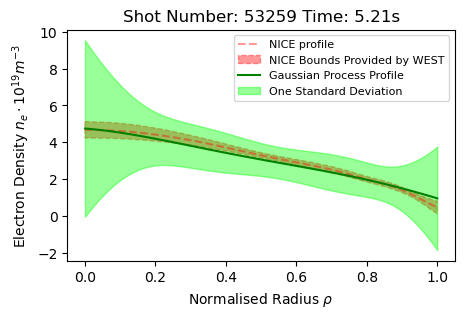

Random Initial Params
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: 34.130703
The length-scale is, l: 0.30521896


FIT RESULTS
   message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 4.265212535858154
        x: [ 3.413e+01  1.315e+00]
      nit: 1
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[1 0]
            [0 1]]
     nfev: 6
     njev: 2
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: 34.13070297241211
The length-scale is, l: 1.3152189648151398
Non positive definate matrix for K even with a small addition of 0 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-10 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-09 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-08 to the diagonal.
Non positive definate matrix for K even with a sma

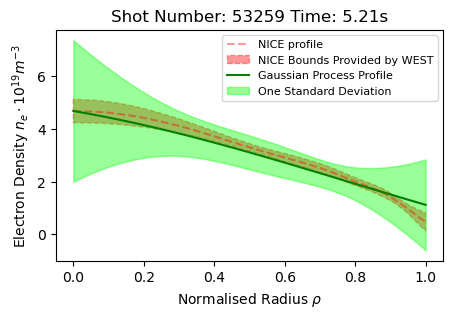

Random Initial Params
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: 23.17728
The length-scale is, l: 0.4550408


FIT RESULTS
   message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 5.2787652015686035
        x: [ 2.318e+01 -5.550e-01]
      nit: 2
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[ 1.000e+00  0.000e+00]
            [ 0.000e+00  1.661e-04]]
     nfev: 30
     njev: 10
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: 23.17728042602539
The length-scale is, l: -0.5549571628440855
Non positive definate matrix for K even with a small addition of 0 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-10 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-09 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-08 to the diagonal.
Non positive

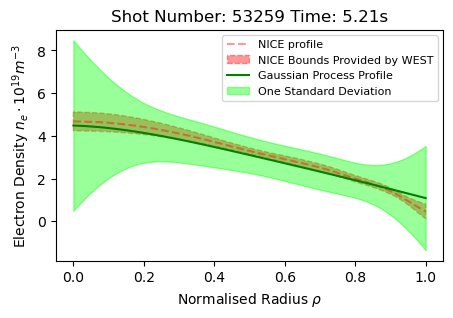

Random Initial Params
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: 28.623598
The length-scale is, l: 0.49805278


FIT RESULTS
   message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 6.338891506195068
        x: [ 2.862e+01  4.981e-01]
      nit: 2
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[ 1.000e+00  0.000e+00]
            [ 0.000e+00  1.354e-11]]
     nfev: 117
     njev: 39
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: 28.623598098754883
The length-scale is, l: 0.498052731686667
Non positive definate matrix for K even with a small addition of 0 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-10 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-09 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-08 to the diagonal.
Non positiv

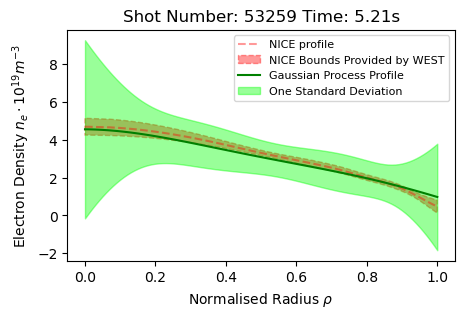

Random Initial Params
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: 46.854168
The length-scale is, l: 0.6556295


FIT RESULTS
   message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 7.05008602142334
        x: [ 4.685e+01  6.556e-01]
      nit: 0
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[1 0]
            [0 1]]
     nfev: 3
     njev: 1
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: 46.854168
The length-scale is, l: 0.6556295
Non positive definate matrix for K even with a small addition of 0 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-10 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-09 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-08 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-0

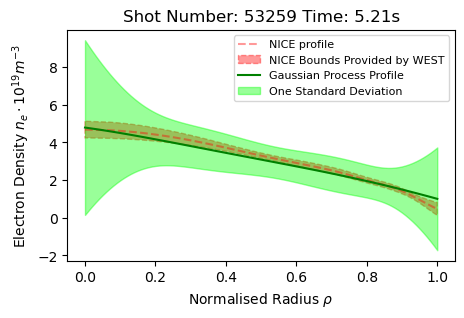

Random Initial Params
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: 15.689844
The length-scale is, l: 0.19809952


FIT RESULTS
   message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 3.2702434062957764
        x: [ 1.569e+01 -8.119e-01]
      nit: 1
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[1 0]
            [0 1]]
     nfev: 6
     njev: 2
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: 15.689844131469727
The length-scale is, l: -0.8119004762172699
Non positive definate matrix for K even with a small addition of 0 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-10 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-09 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-08 to the diagonal.
Non positive definate matrix for K even with a 

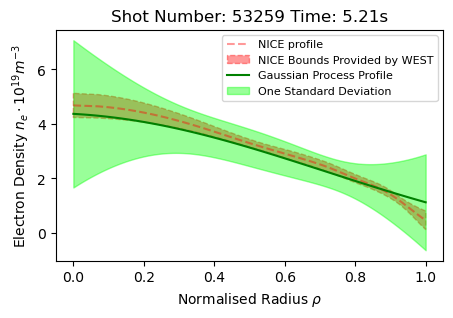

Random Initial Params
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: 20.809608
The length-scale is, l: 0.2844012


FIT RESULTS
   message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 3.1498656272888184
        x: [ 2.081e+01  1.294e+00]
      nit: 1
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[1 0]
            [0 1]]
     nfev: 6
     njev: 2
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: 20.809608459472656
The length-scale is, l: 1.2944012081623077
Non positive definate matrix for K even with a small addition of 0 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-10 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-09 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-08 to the diagonal.
Non positive definate matrix for K even with a sm

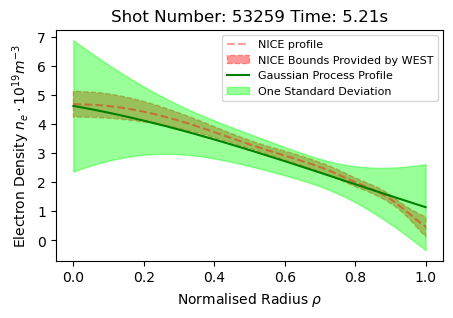



Best of all initial params


Random Initial Params
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: 20.809608
The length-scale is, l: 0.2844012


Fitted Params
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: 20.809608459472656
The length-scale is, l: 1.2944012081623077
Non positive definate matrix for K even with a small addition of 0 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-10 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-09 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-08 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-07 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-06 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-05 to the diagonal.
Non pos

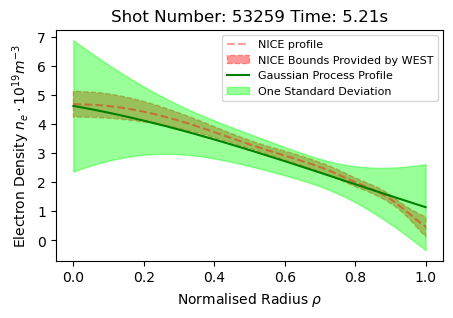

 82%|███████████████████████████████████▏       | 81/99 [18:07<04:13, 14.07s/it]

In [ ]:
#Performing GPR
# always no extra info
class ForwardGPR(object):
    def __init__(self, rho_test, lid_d, lid_error, Kernel,
                 initial_params=None, prior_mu='non-informative'):
                
        self.data = lid_d
        self.lid_error = lid_error
        self.rho_test = rho_test
        self.N = len(rho_test)
        self.M = len(lid_d)
        self.initial_params = initial_params
        
        if prior_mu == 'non-informative':
            self.prior_mu = torch.zeros(self.N)
        else: self.prior_mu = prior_mu
        
        self.post_mu = None
        self.post_cov = None
        
        #grid search
        self.grid_best_marge_li = float('inf')
        self.grid_best_params = None
        
        self.suitable_params_range = None
        self.num_grid_squares_1d = None
        self.marginal_likelyhood_grid = None
        
        #SciPy
        self.scipy_best_params = None
        self.scipy_best_marge_li = None
        self.scipy_best_rand_init_params = None
        
    def MakePosDef(self, A, name='Matrix'):
        small = [0] + [1*10**(-o) for o in reversed(range(1,11))]
        for sm in small:
            A += torch.diag_embed(torch.tensor(sm).repeat(A.shape[0]))
            try:
                L = torch.linalg.cholesky(A)#ensures not positive definate
                torch.inverse(L) # ensures not singular
                if sm>0:
                    print('For '+name+' a small addition of', sm ,
                          'to the diagonal was needed to ensure it was positive devinate and its lower cholesky is not singular.')
                return A 

            except torch.linalg.LinAlgError:
                print("Non positive definate matrix for "+name+" even with a small addition of", sm ,
                      "to the diagonal.")
                if sm == small[-1]: raise torch.linalg.LinAlgError('No small addition along the diagonal was',
                                                                   'enough to ensure the matrix is positive definate.')

    def chol_inv(self, A, name='Matrix'):
        A = self.MakePosDef(A, name)
        L = torch.linalg.cholesky(A)
        return torch.inverse(L).T @ torch.inverse(L)

    def chol_det(self, A, name='Matrix'):
        A = self.MakePosDef(A, name)
        L = torch.linalg.cholesky(A)
        return torch.prod(torch.diag(L))
        
    def KRcov_li(self, params):            
        #covergence matrix of Prior
        K = Kernel(self.rho_test, self.rho_test, params, tensor=True)
        #cov_li is covergence matrix of Likelyhood
        R = torch.from_numpy(compute_response_matrix(geo, equi, self.rho_test.numpy()))    
        cov_li = torch.diag(torch.tensor(lid_error)) # M is number of channels
        return K.float(), R.float(), cov_li.float()
    
    def MargeLi(self, params):    
        K, R, cov_li = self.KRcov_li(params)
        invertable = (cov_li + R @ K @ R.T).float()
        #my marge_li
        marge_li = torch.log(self.chol_det(invertable,name='Invertable, Det')) +(self.data@self.chol_inv(invertable, name='Invertable, Inv')@self.data)
        return marge_li
           
    def GridSearch(self, suitable_params_range, num_grid_squares_1d):
        self.suitable_params_range = suitable_params_range
        self.num_grid_squares_1d = num_grid_squares_1d
        
        params_vectors = [np.linspace(spr[0],spr[1],num_grid_squares_1d) for spr in suitable_params_range]
        amp_v = params_vectors[0]
        l_v = params_vectors[1]    
        
        shape = [num_grid_squares_1d for pv in params_vectors]
        marginal_likelyhood_grid = np.zeros(shape)

        pbar = tqdm(range(1,len(amp_v)))
        for amp_i in pbar:
            for l_i in range(1,len(l_v)):
                params = [amp_v[amp_i],l_v[l_i]]
                marginal_likelyhood_grid[amp_i, l_i] = self.MargeLi(params=[amp_v[amp_i],l_v[l_i]])
                loss = marginal_likelyhood_grid[amp_i, l_i]
                if loss < self.grid_best_marge_li:
                    self.grid_best_marge_li = loss
                    self.grid_best_params = [amp_v[amp_i], l_v[l_i]]

        self.marginal_likelyhood_grid = marginal_likelyhood_grid
        return marginal_likelyhood_grid
    
    def PlotGrid(self):
        params_vectors = [np.linspace(spr[0],spr[1],self.num_grid_squares_1d) for spr in self.suitable_params_range]
        amp_v = params_vectors[0]
        l_v = params_vectors[1]
        seabourn = sn.heatmap(interf.marginal_likelyhood_grid,cmap='viridis',cbar_kws={'label':'ML'},square=True,
                   xticklabels=[np.format_float_positional(l_v_i, precision=2, unique=False, fractional=False, trim='k') for l_v_i in l_v], 
                   yticklabels=[np.format_float_positional(amp_v_i, precision=2, unique=False, fractional=False, trim='k') for amp_v_i in amp_v])
        ax2 = seabourn.axes
        ax2.set_xticklabels(ax2.get_xticks(), rotation=90)
        ax2.set_yticklabels(ax2.get_yticks(), rotation=180*2)
        plt.xlabel('Length Scale')
        plt.ylabel('Amplitude')
        plt.show() 
                
    def SciPyFit(self, method='minimize', NUM_RANDOM_SEARCHES=1): 
        print('Performing SciPy fitting using method:',method)
        #getting a set of random initial parameters
        if NUM_RANDOM_SEARCHES==0:
            kernel_params = (initial_params,)
        else:
            kernel_params = RandomKernelInit(NUM_RANDOM_SEARCHES, tensor=False)
        #---------------------------------
        for kp in kernel_params:
            print('Random Initial Params')
            Plot_l(rho_1d,kp, tensor=False)
            best_loss = float('inf')
            if method=='basinhopping':
                optimize = basinhopping
                args = ()
                kargs = {'niter':10}
                    
            elif method == 'minimize': 
                optimize = minimize
                args = ()
                kargs = {'options':{'maxiter':1000}, 'tol':1e-20}
            
            results = optimize(self.MargeLi, x0=kp, *args, **kargs)
            print("\n\nFIT RESULTS\n",results)
            loss = self.MargeLi(results.x)
            Plot_l(rho_1d,results.x, tensor=False)
            self.Infer(results.x)
            self.PlotInference()
            if loss < best_loss and results.success:
                best_loss = loss
                self.scipy_best_params = results.x
                self.scipy_best_marge_li = loss
                self.scipy_best_rand_init_params = kp
        print('\n\nBest of all initial params')
        print('\n\nRandom Initial Params')
        Plot_l(rho_1d,self.scipy_best_rand_init_params, tensor=False)
        print('\n\nFitted Params')
        Plot_l(rho_1d,self.scipy_best_params, tensor=False)
        self.Infer(self.scipy_best_params)
        self.PlotInference()
            
    def Infer(self, params):                   
        K, R, cov_li = self.KRcov_li(params)
        self.post_cov = self.chol_inv(R.T @ self.chol_inv(cov_li, name='Likelihood Covariance') @ R + self.chol_inv(K, name='K'))
        self.post_mu = self.prior_mu + self.post_cov @ R.T @ self.chol_inv(cov_li, name='Likelyhood Covariance') @ (self.data - R @ self.prior_mu)            
        self.marge_li = self.MargeLi(params)                     
        
    def PlotInference(self):
        post_mu = self.post_mu.detach()
        std = torch.sqrt(torch.diagonal(self.post_cov)).detach()
        
        figGPR3 = plt.figure(figsize=(5,3))
        plt.title('Shot Number: '+str(shot)+' Time: '+str(t)+'s')
        plt.xlabel(r'Normalised Radius $\rho$')
        plt.ylabel(r'Electron Density $n_e \cdot 10^{19} m^{-3}$')
        plt.plot(rho_1d, nice,color=(1,0,0,0.4), linestyle='--', label='NICE profile')
        plt.fill_between(rho_1d, dens_prof.dens_1d_lower, dens_prof.dens_1d_upper, color=(1,0,0,0.4),linestyle='--',label='NICE Bounds Provided by WEST')
        plt.plot(self.rho_test, post_mu,'g', label='Gaussian Process Profile')
        plt.fill_between(self.rho_test, post_mu-std, post_mu+std, color=(0,1,0,0.4),linestyle='-',label='One Standard Deviation')
        plt.legend(fontsize = 8)
        plt.show()

EXP_ER = 0.5
lid_error = torch.tensor([EXP_ER]).repeat(interf_M).float()
N=101
rho_test=torch.linspace(0,1,N).float()

lid_d_torch = torch.from_numpy(lid_d).float()
initial_params_tensor = [torch.tensor([p], requires_grad=False) for p in initial_params]

#sets the seed so the randomness can be repeated exactly the same each time
ReSeed(1)


interf = ForwardGPR(rho_test=rho_test, lid_d=lid_d_torch,
                    lid_error=lid_error, 
                    Kernel=Kernel,
                    initial_params=initial_params_tensor, 
                    prior_mu='non-informative')

# interf.SciPyFit(method='basinhopping', NUM_RANDOM_SEARCHES=3)
interf.SciPyFit(NUM_RANDOM_SEARCHES=12)

interf.GridSearch(suitable_params_range, num_grid_squares_1d=100)

# interf.Infer(interf.initial_params)
# interf.PlotInference()

In [ ]:
interf.GridSearch(suitable_params_range, num_grid_squares_1d=100)